# Model Performance Evaluation
This notebook can be used to find the best model for each dataset, and compare the best model across datasets as well as calculating the confusion matrices for a model in `allDataModelDict`. Confusion matrices are calculated using **either** validation set, or the training set along with cross validation. This is done because some models will have been trained either using a single validation dataset, or cross validation on a single training dataset. Note that the cv confusion matrix is refitting the model 5 times, and calculating predictions/scores for the heldout data, while if a validation dataset is supplied then the model is not refit

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import csv
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
import copy
from src.mlPipeline.plotting import plotBestModelComparison, plotDatasetModelComparison
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
modelDictPath = "data/featureImportanceTestData/modelDictMultiDataRun_datasets_1_2_3_7_20190722.pkl"
# modelDictPath = "data/modelDictMultiDataRun.pkl"
with open(modelDictPath, "rb") as pklFile:
    allDataModelDict = pickle.load(pklFile)

Dataset with all zero f1 scores are being removed from plots
{   'dataset_1_': (   'randomForest',
                      0.8606851260205893,
                      0.03955514726881173,
                      0.7688006525122791,
                      0.06554457654866763),
    'dataset_2_': (   'logistic',
                      0.9101667190940547,
                      0.05837736911642095,
                      0.6163870733478577,
                      0.09260364039064797),
    'dataset_3_': (   'randomForest',
                      0.8768657896468157,
                      0.018302238351984995,
                      0.6992008609228033,
                      0.05797920760245249),
    'dataset_7_': (   'logistic',
                      0.9014461517656406,
                      0.025712909197705816,
                      0.7783872401697675,
                      0.061057655880505934)}


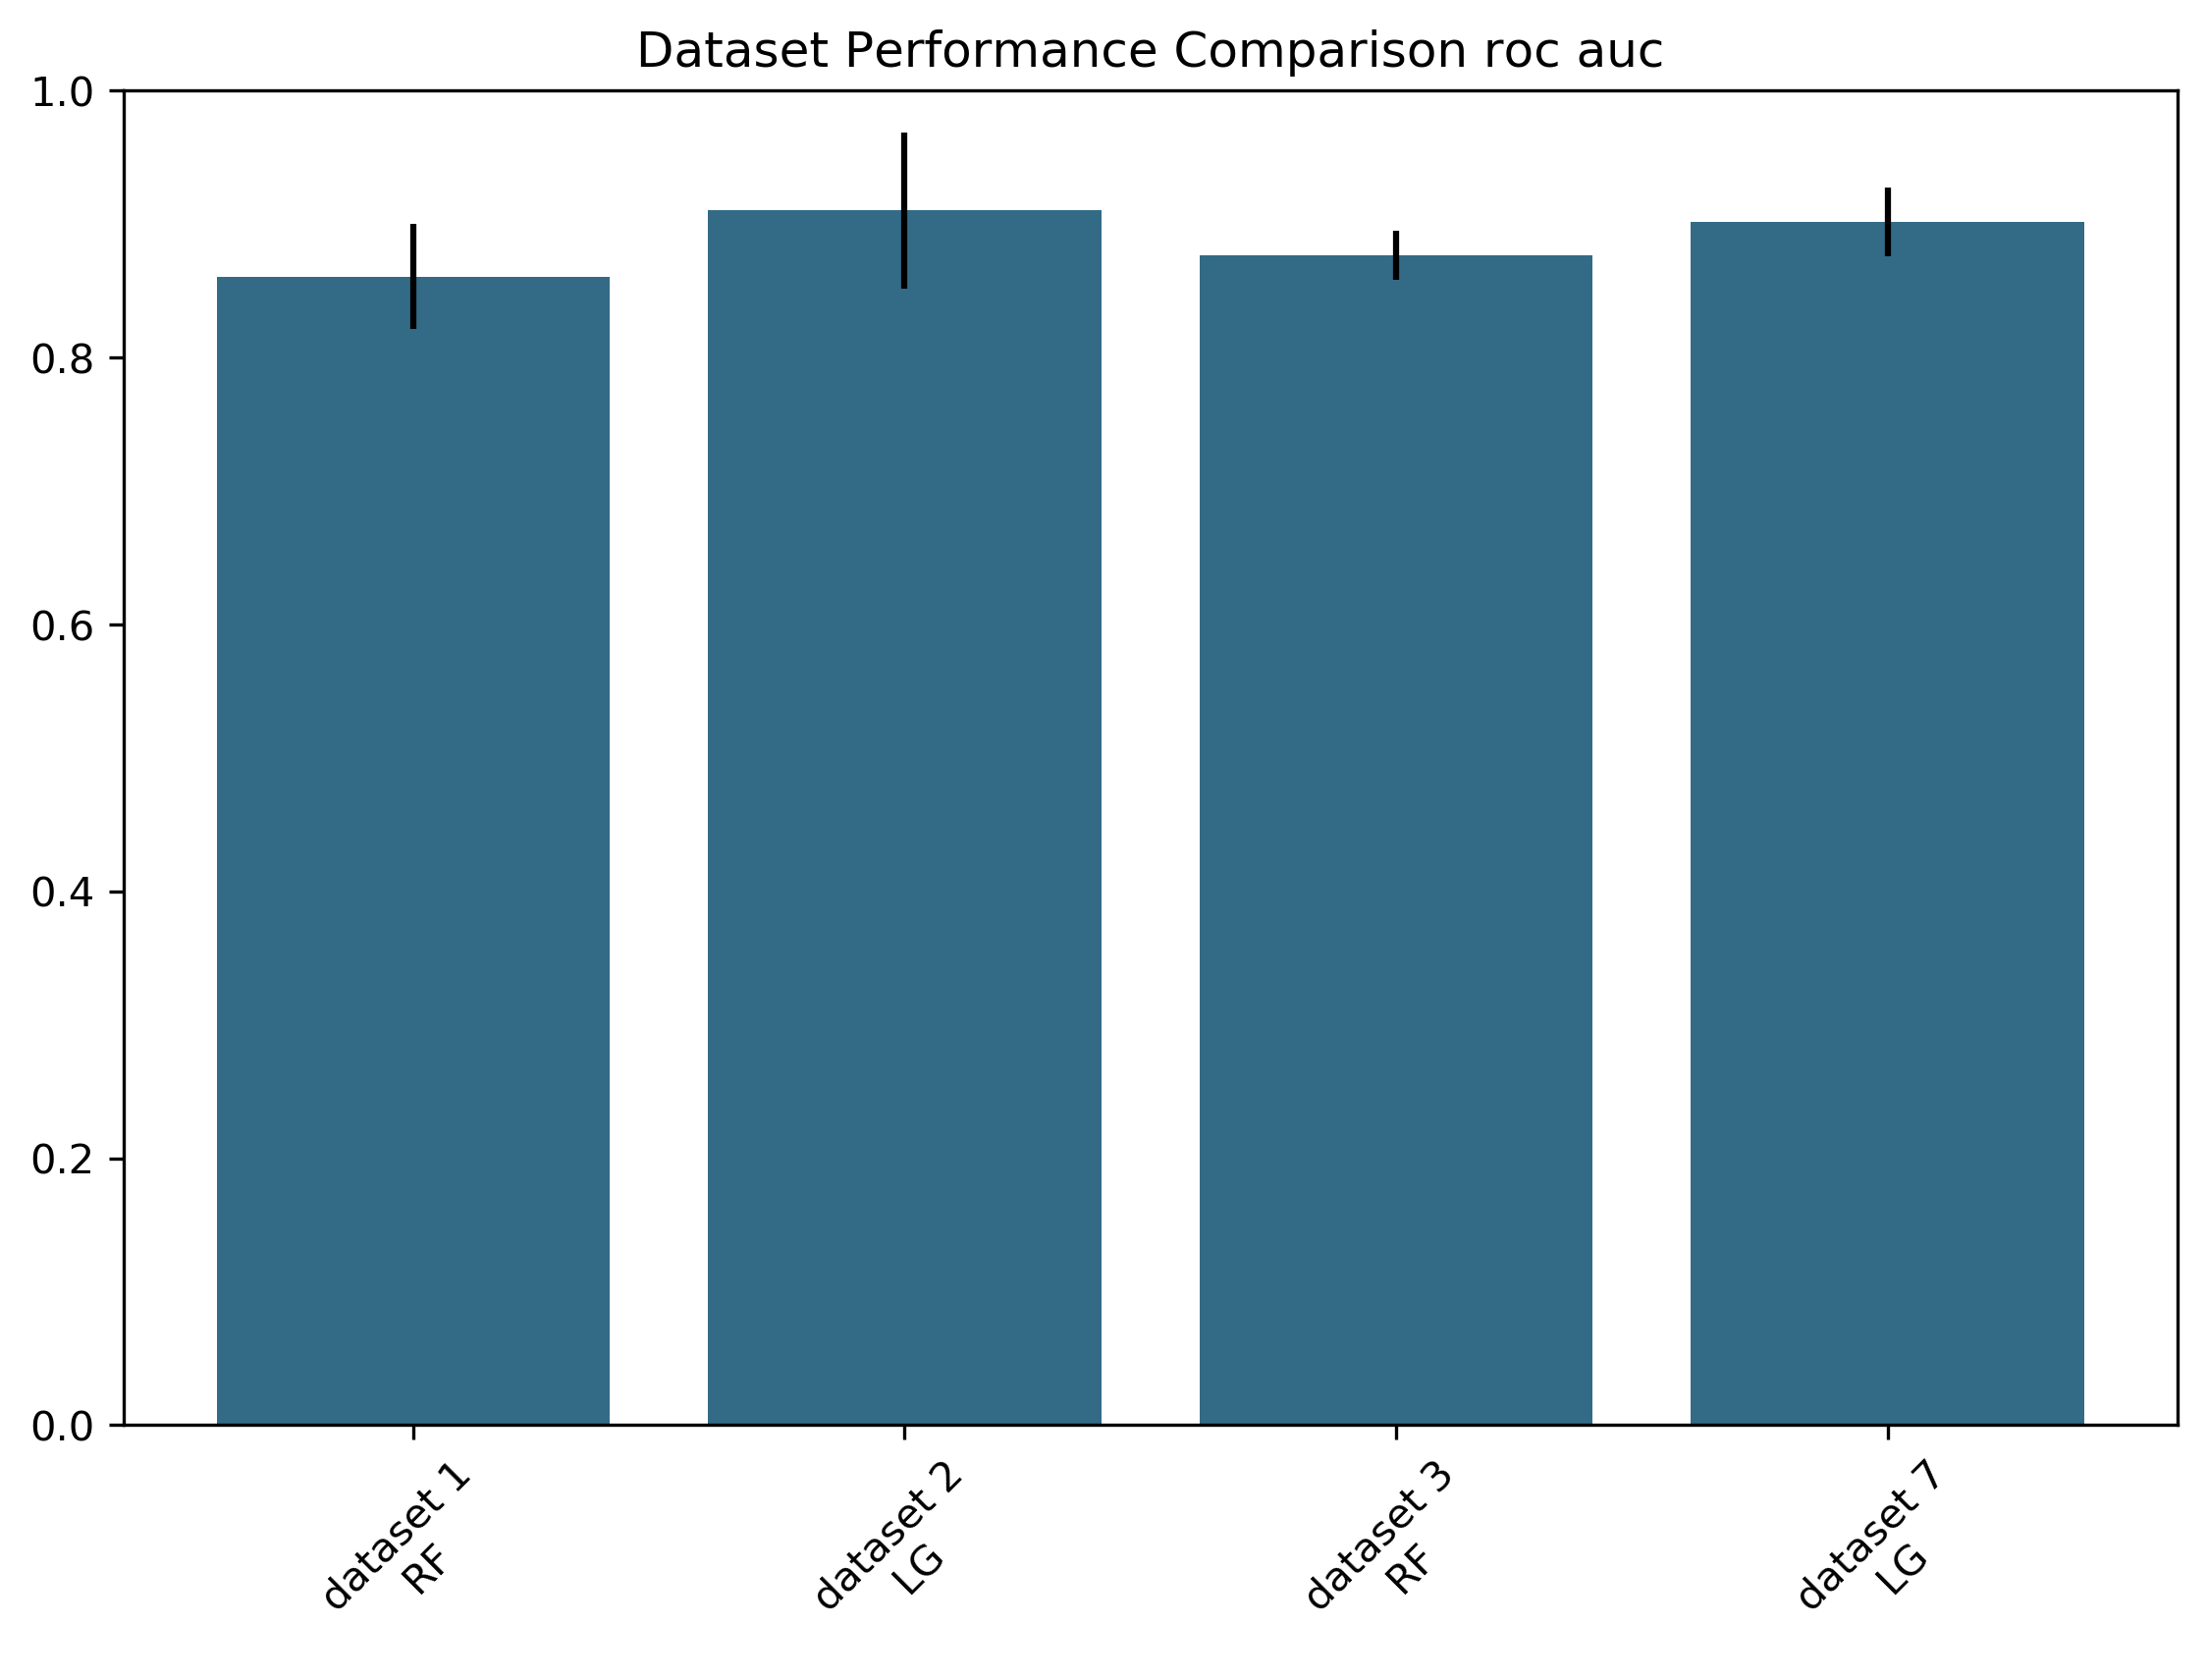

In [3]:
dataSetComparisonList = list(allDataModelDict.keys())
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = allDataModelDict,
                           dataSetComparisonList = dataSetComparisonList,
                               compMetric = "roc_auc", removeZeroF1Score = True)
pp.pprint(datasetBestModelDict)

In [4]:
def readData(myDataPath):
    isolateList = []
    with open(myDataPath) as fp:
        csvReader = csv.reader(fp)
        header = next(csvReader)
    if len(header) > 100000:
        print("Reading large data with more efficient code")
        with open(myDataPath) as fp:
            csvReader = csv.reader(fp)
            header = next(csvReader)
            for line in csvReader:
                isolateList.append(line[0])
        df = np.loadtxt(myDataPath, delimiter = ",", skiprows = 1, usecols = range(1, len(header))) 
        df = pd.DataFrame(df, columns = header[1:])
        df.insert(loc = 0, column = "isolate", value = isolateList) 
    else:
        df = pd.read_csv(myDataPath)
    return(df)

In [24]:
modelName = "randomForest"
assert modelName in ["randomForest", "GBTC", "logistic", "SVC"], "invalid model name."
##################################################
#######################NOTE#######################
##################################################
# Be sure that the dataPath and dataSetOfInterest
# correspond to the same dataset used to train the
# models.
# Also, only one must be not None. Either the validation
# or training data. If validation data is not none, then
# all metrics are calculated using the validation dataset
# otherwise all metrics are calculated on the training
# dataset using cross validation
dataSetOfInterest = "dataset_1_"
dataPath_train = "data/featureImportanceTestData/dataset_1_full.csv"
dataPath_val = None
modelDict = allDataModelDict[dataSetOfInterest][modelName]
bestModel = modelDict["gridcv"].best_estimator_


assert (dataPath_val is not None) or (dataPath_train is not None),\
    "validation or train dataPath must not be none."

if dataPath_val is not None:
    assert dataPath_train is None, "only one path must be not None"
    df = readData(dataPath_val)
elif dataPath_train is not None:
    assert dataPath_val is None, "only one path must be not None"
    df = readData(dataPath_train)
    
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X_val = X_df.values
Y_df = df["pbr_res"]
Y_val = Y_df.values 

if dataPath_val is not None:
    print("All predictions are obtained using the validation set")
    preds = bestModel.predict(X_val)
    if modelName != "SVC":
        scores = bestModel.predict_proba(X_val)
    else:# probs not available for SVC
        scores = None
    f1 = f1_score(y_true = Y_val, y_pred = preds)
    prec = precision_score(y_true = Y_val, y_pred = preds)
    rec = recall_score(y_true = Y_val, y_pred = preds)
else:
    print("All prediction are obtained using cross validation on the training set")
    scores = cross_val_predict(bestModel, X_val, Y_val, method = "predict_proba", cv = 5)
    preds = np.argmax(scores, axis = 1)
if modelName != "SVC":
    rocauc = roc_auc_score(y_true = Y_val, y_score = scores[:,1])
else:# probs not available for SVC
    rocauc = None
f1 = f1_score(y_true = Y_val, y_pred = preds)
prec = precision_score(y_true = Y_val, y_pred = preds)
rec = recall_score(y_true = Y_val, y_pred = preds)
print("rocauc: {}".format(rocauc))
print("f1: {}".format(f1))
print("prec: {}".format(prec))
print("rec: {}".format(rec))
print("confusion matrix. truth by prediction",\
      "0,0 = true negative, 1,0 = false negatives, 1,1=true positives and 0,1=false positives",
     "please see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"\
      " for more information.")
print(confusion_matrix(y_true = Y_val, y_pred = preds))


All prediction are obtained using cross validation on the training set
rocauc: 0.8458592132505176
f1: 0.7330677290836654
prec: 0.8141592920353983
rec: 0.6666666666666666
confusion matrix. truth by prediction 0,0 = true negative, 1,0 = false negatives, 1,1=true positives and 0,1=false positives please see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html for more information.
[[154  21]
 [ 46  92]]
